In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
from IPython.display import display, clear_output
import helpfunction as helper
import matplotlib.patches as patches

pd.set_option('display.max_columns', 500)

In [3]:
%autoreload

In [4]:
gr = (1 + 5 ** 0.5) / 2
outdir= './output/NuMuCC/'
inputdir = './input/ImprovedMay/run3/' 
main_tree_name= 'pandoraSliceId' #'pandoraFlashEventBuilding

In [5]:
dict_names = ['nue','nu','on','off', 'dirt']

fidvol_vtx = [10,10,10,10,10,50] 
fidvol_end = [5,5,5,5,5,5]

lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]

mass_mu = 0.106
kin_min = 0.02
kin_min_mu = kin_min + mass_mu

In [6]:
#triggers_off = 15060902
#triggers_on = 10701086
#pot_on = 4.535e19
#pot_nue = 4.69e+22
#pot_nu = 2.42e+20
#pot_dirt = 1.08e+20

triggers_off = 15060902
triggers_on = 10701086
pot_on = 1.54e+18 #4.535e19
pot_nue = 4.69e+22
pot_nu = 2.42e+20
pot_dirt = 1.08e+20

title_str = "MicroBooNE {0:.2g} POT, INTERNAL".format(pot_on)
sig_str = r"$\nu_e \: CC$"
scale_off = triggers_on / triggers_off
scale_nu = pot_on / pot_nu
scale_nue = pot_on / pot_nue
scale_on = 1
scale_dirt = pot_on / pot_dirt

#['nue','nu','on','off', 'dirt'] 
scales = [scale_nue, scale_nu, scale_on, scale_off, scale_dirt]
scales = [0.0003164940068271165, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402]
#scales = [0.0013624287664904839, 0.3985858831402375, 1, 0.2680639281813817, 0.4285156805726306]
print(scales)

[0.0003164940068271165, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402]


In [7]:
def eventHash(df):
    return df.apply(lambda x: hash(tuple(x)), axis = 1)

def EffPurPrinter(num_pass):
    eff = num_pass[0]/num_nue_sig_start
    eff_err = helper.effErr(num_pass[0],num_nue_sig_start)
    
    off_eff = num_pass[3]/num_off_start
    off_err = helper.effErr(num_pass[3],num_off_start)
    
    pure_mc = num_pass[0]*scales[0]/(num_pass[1]*scales[1])
    pure_mc_err = helper.effErr(num_pass[0]*scales[0],num_pass[1]*scales[1])
    
    pure = num_pass[0]*scales[0]/(num_pass[1]*scales[1]+num_pass[3]*scales[3])
    pure_err = helper.effErr(num_pass[0]*scales[0],num_pass[1]*scales[1]+num_pass[3]*scales[3])
    
    ratio = num_pass[2]*scales[2]/(num_pass[1]*scales[1]+num_pass[3]*scales[3])
    
    print('Eff: ({0:.2f}+-{1:.2f})%'.format(eff*100,eff_err*100), end="")
    print('\tPurity_MC: ({0:.2f}+-{1:.2f})%'.format(pure_mc*100,pure_mc_err*100), end="")
    print('\tPurity: ({0:.2f}+-{1:.2f})%'.format(pure*100,pure_err*100), end="")
    print('\tData/MC: {0:.2f}'.format(ratio), end="")
    print('\t Off passing fraq: ({0:.2f}+-{1:.2f})%'.format(off_eff*100,off_err*100), end="")
    print()
    
def inTPC_mask(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return mask

def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    mask = inTPC_mask(df, str_x, str_y, str_z, fidvol)
    return df[mask]

def cosmic_angles(mom_x, mom_y, mom_z,df_out=True):
    theta_beam = np.arctan2(np.sqrt(np.square(mom_x)+np.square(mom_y)),mom_z)
    phi_beam = np.arctan2(mom_y,mom_x)
    if df_out:
        return pd.DataFrame({'theta':theta_beam, 'phi':phi_beam})[['theta','phi']]
    else:
        return np.array([theta_beam, phi_beam])

In [8]:
file_dict = {}
tree_names = ['']

flist =  os.listdir(inputdir)
for sample,scale in zip(dict_names, scales):
    file_name = next((s for s in flist if "NueCC_"+sample in s), None)
    file_dict[sample] = {}
    file_dict[sample]["all_events"] = uproot.open(inputdir+file_name)[main_tree_name+'/events']
    file_dict[sample]["slices"] = uproot.open(inputdir+file_name)[main_tree_name+'/slices']
    file_dict[sample]["events"] = uproot.open(inputdir+file_name)['nueCCAnalyser/Event']
    file_dict[sample]["daughters"] = uproot.open(inputdir+file_name)['nueCCAnalyser/Daughters']
    
    
    print(sample+":\tAll events: ", file_dict[sample]["all_events"].numentries, end="")
    print("\tSelected events: ", file_dict[sample]["events"].numentries, end="")
    print("\tScaled to data: ", round(file_dict[sample]["events"].numentries*scale))

nue:	All events:  10337	Selected events:  8615	Scaled to data:  3
nu:	All events:  11858	Selected events:  5607	Scaled to data:  729
on:	All events:  6572	Selected events:  1784	Scaled to data:  1784
off:	All events:  65335	Selected events:  13482	Scaled to data:  869
dirt:	All events:  39506	Selected events:  10915	Scaled to data:  160


In [9]:
sample = "nu"
for name in file_dict[sample]:
    print('\n*** ', name, ' ***')
    print([c.decode('UTF-8') for c in file_dict[sample][name].keys()])


***  slices  ***
['sliceId', 'run', 'subRun', 'event', 'evt_time_sec', 'evt_time_nsec', 'hasDeposition', 'totalCharge', 'centerX', 'centerY', 'centerZ', 'minCRTdist', 'CRTtime', 'CRTplane', 'deltaY', 'deltaZ', 'deltaYSigma', 'deltaZSigma', 'chargeToLightRatio', 'xclVariable', 'passesPreCuts', 'flashMatchScore', 'totalPEHypothesis', 'peHypothesisSpectrum', 'isTaggedAsTarget', 'targetMethod', 'isConsideredByFlashId', 'topologicalScore', 'hasBestTopologicalScore', 'hasBestFlashMatchScore', 'nHits', 'purity', 'completeness', 'isMostComplete', 'nuInteractionType', 'nuCCNC', 'nuEnergy', 'leptonEnergy', 'nuInteractionTime', 'nuPdgCode', 'nuVertexX', 'nuVertexY', 'nuVertexZ']

***  events  ***
['event', 'run', 'subrun', 'evt_time_sec', 'evt_time_nsec', 'numpfp', 'hitsU', 'hitsV', 'hitsY', 'caloU', 'caloV', 'caloY', 'hitsSps', 'num_primary_daughters', 'num_daughters', 'num_showers', 'num_tracks', 'daughters_stored', 'nu_vx', 'nu_vy', 'nu_vz', 'nu_pdg', 'num_neutrinos', 'mc_nu_vx', 'mc_nu_vy', 

In [10]:
df_daughters = [file_dict[sample]["daughters"].pandas.df() for sample in dict_names]

In [11]:
# for the nu events:
cols = ['mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', 'mc_nu_lepton_energy', 'mc_nu_lepton_theta','mc_nu_ccnc', 'mc_nu_pdg']
df_nu_event = file_dict['nu']["events"].pandas.df(cols)
nu_tpc_mask = inTPC_mask( df_nu_event, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz')
df_nu_event['mc_nu_fid_vol'] = inTPC_mask( df_nu_event, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', fidvol=fidvol_vtx)
nu_sig_mask = df_nu_event.eval('mc_nu_lepton_energy>@kin_min_mu & ~mc_nu_ccnc & abs(mc_nu_pdg)==14 & mc_nu_fid_vol')

In [12]:
# Add a bunch of stuff to the daughter frames to do the selection
for i,s in enumerate(dict_names):
    #do not care about the nue, replace that later by the numuccsig
    if s == 'nue':
        continue
    start = time.time()
    print(s)
    df_daughters[i]['hash'] = eventHash(df_daughters[i][['evt_time_sec', 'evt_time_nsec']])
    
    # do for all:
    start_mask = inTPC_mask(df_daughters[i], 'vx', 'vy', 'vz', fidvol_vtx)
    end_mask = inTPC_mask(df_daughters[i], 'track_endx', 'track_endy', 'track_endz', fidvol_end)
    df_daughters[i]['contained'] = start_mask & end_mask 
    df_daughters[i]['start_contained'] = start_mask
    df_daughters[i]['all_contained'] = df_daughters[i].groupby(['hash'])['contained'].transform(all)
    df_daughters[i]['all_start_contained'] = df_daughters[i].groupby(['hash'])['start_contained'].transform(all)
    
    # Add the pandora PDG code of the parent:
    df_event = file_dict[s]["events"].pandas.df(['evt_time_sec','evt_time_nsec','nu_pdg', 'caloY','num_tracks'])
    df_event['hash'] = eventHash(df_event[['evt_time_sec', 'evt_time_nsec']])
    mapper = dict(zip(df_event['hash'],df_event['nu_pdg']))
    df_daughters[i]['nu_pdg'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],df_event['caloY']))
    df_daughters[i]['caloY'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],df_event['num_tracks']))
    df_daughters[i]['num_tracks'] = df_daughters[i]['hash'].map(mapper)
    
    df_all_event = file_dict[s]["all_events"].pandas.df(['evt_time_sec','evt_time_nsec','bestCosmicMatch'])
    df_all_event['hash'] = eventHash(df_all_event[['evt_time_sec', 'evt_time_nsec']])
    mapper = dict(zip(df_all_event['hash'],df_all_event['bestCosmicMatch']))
    df_daughters[i]['bestCosmicMatch'] = df_daughters[i]['hash'].map(mapper)
    
    # Add the topological score and the chi2
    df_slices = file_dict[s]["slices"].pandas.df(['evt_time_sec','evt_time_nsec','topologicalScore', 'flashMatchScore', 'isTaggedAsTarget', 'minCRTdist'])
    df_slices = df_slices.query('isTaggedAsTarget')
    df_slices['hash'] = eventHash(df_slices[['evt_time_sec', 'evt_time_nsec']])
    mapper = dict(zip(df_slices['hash'],df_slices['topologicalScore']))
    df_daughters[i]['topologicalScore'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_slices['hash'],df_slices['flashMatchScore']))
    df_daughters[i]['flashMatchScore'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_slices['hash'],df_slices['minCRTdist']))
    df_daughters[i]['minCRTdist'] = df_daughters[i]['hash'].map(mapper)
    
    df_daughters[i]['longest_track_length'] = df_daughters[i].groupby(['hash'])['track_length'].transform(max)
    # there can be only one muon candidate per event!
    df_daughters[i]['muon_candidate'] = df_daughters[i].eval('track_score>0.9 & vtx_distance<5 & longest_track_length==track_length')
    df_daughters[i]['all_muon_candidate'] = df_daughters[i].groupby(['hash'])['muon_candidate'].transform(any)
    
    #do for mc only 
    if s == 'nu':
        mapper = dict(zip(df_event['hash'],nu_tpc_mask))
        df_daughters[i]['mc_nu_in_tpc'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_event['hash'],nu_sig_mask))
        df_daughters[i]['mc_nu_cc_sig'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_event['hash'],file_dict[s]["events"].array('mc_nu_lepton_energy')))
        df_daughters[i]['mc_nu_lepton_energy'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_event['hash'],file_dict[s]["events"].array('mc_nu_lepton_theta')))
        df_daughters[i]['mc_nu_lepton_theta'] = df_daughters[i]['hash'].map(mapper)
    end = time.time()
    print("Passed time: {0:0.1f}s".format(end - start))

nu
Passed time: 3.8s
on
Passed time: 1.3s
off
Passed time: 9.6s
dirt
Passed time: 7.4s


In [13]:
for i,s in enumerate(dict_names):
    #do not care about the nue, replace that later by the numuccsig
    if s == 'nue':
        continue
    
    df_daughters[i][['theta_beam','phi_beam']] = cosmic_angles(*df_daughters[i][['track_dirx', 'track_diry', 'track_dirz']].T.values)

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in sqrt


In [14]:
# pdgcode = 14
# at least one track over 30cm and vtx distance < 5 and score>0.9
# all daughters contained
# chi2<10 OR topo>0.4
# topo > 0.05
df_daughters[0] = df_daughters[1].query('mc_nu_cc_sig')

In [33]:
query_event_wo_trackcut = 'nu_pdg==14 & (flashMatchScore<10 | topologicalScore>0.4) & all_start_contained & muon_candidate & topologicalScore>0.087 & (flashMatchScore/bestCosmicMatch)<4 & minCRTdist>15'
query_event = 'nu_pdg==14 & (flashMatchScore<10 | topologicalScore>0.4) & all_start_contained & muon_candidate & topologicalScore>0.087 & (flashMatchScore/bestCosmicMatch)<4 & track_length>30 & minCRTdist>15'
eff = len(df_daughters[0].query(query_event))/sum(nu_sig_mask)*100
print(eff)

55.81824898411526


[0.129954152163159, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402, 0.129954152163159]


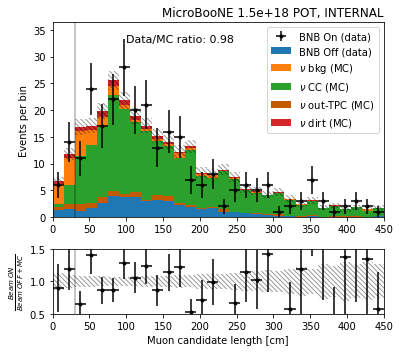

In [34]:
#track plot
fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(3.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

# Left
lab = 'Muon candidate length [cm]'
N=30
x_min = 0
x_max = 450
data = [df_daughters[i].query(query_event_wo_trackcut)['track_length'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_event_wo_trackcut).query('~mc_nu_in_tpc')['track_length'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0].set_ylabel('Events per bin')
ax[0].set_title(title_str, loc='right')
ax[0].set_ylim(0,1.3*max_val[2])
ax[0].text(100, ax[0].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
ax[0].set_xlim(x_min,x_max)
ax[0].axvline(x=30, color='k', alpha=0.3)
ax[0].legend()

# Ratio plots
ax[1].set_ylim(0.5,1.5)
ax[1].set_xlim(x_min,x_max)
ax[1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1].set_xlabel(lab)
ax[1].axvline(x=30, color='k', alpha=0.3)

fig.tight_layout()
fig.savefig(outdir+"numu_tracklength.pdf", bbox_inches="tight")

In [35]:
#on_contribution = df_daughters[2].query(query_event)*scales_here[2]
off_contribution = len(df_daughters[3].query(query_event))*scales_here[3]
nu_contribution = len(df_daughters[1].query(query_event))*scales_here[1]
dirt_contribution = len(df_daughters[4].query(query_event))*scales_here[4]

purity= len(df_daughters[0].query(query_event))*scales_here[0] / (off_contribution+nu_contribution+dirt_contribution)
print(purity)

0.7217945753019843


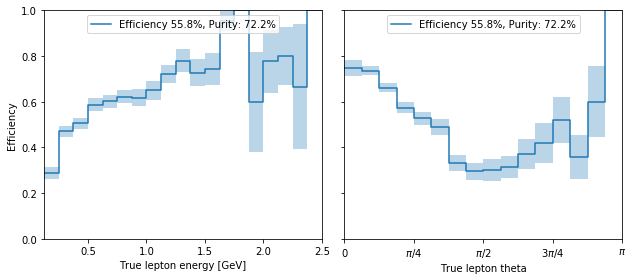

In [36]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5.5*gr,4), sharey=True)

# Left
x_min = 0.125
x_max = 2.5
N = 19
denom = df_nu_event['mc_nu_lepton_energy'][nu_sig_mask]
nom = df_daughters[0].query(query_event)['mc_nu_lepton_energy']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'True lepton energy [GeV]')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[0].legend(loc='upper center')

# Right
x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']
x_min = 0
x_max = np.pi
N = 16
denom = df_nu_event['mc_nu_lepton_theta'][nu_sig_mask]
nom = df_daughters[0].query(query_event)['mc_nu_lepton_theta']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'True lepton theta')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[1].legend(loc='upper center')
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)

fig.tight_layout()
fig.savefig(outdir+"eff.pdf", bbox_inches="tight")

[0.129954152163159, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402, 0.129954152163159]


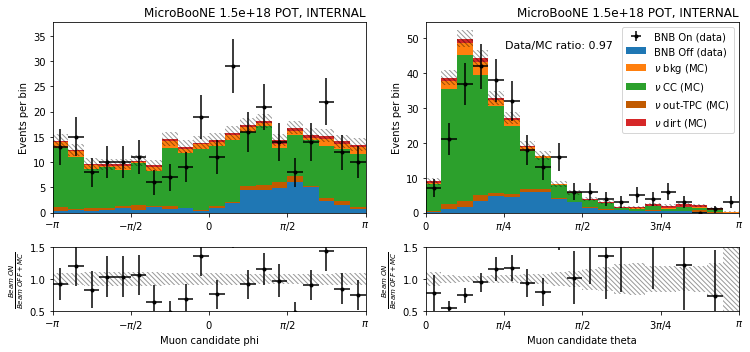

In [37]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(6.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

# Left
lab = 'Muon candidate phi'
x_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
x_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$',r'$\pi/2$',r'$\pi$']
N=20
x_min = -np.pi
x_max = np.pi
data = [df_daughters[i].query(query_event)['phi_beam'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_event).query('~mc_nu_in_tpc')['phi_beam'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0][0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][0].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0][0].set_ylabel('Events per bin')
ax[0][0].set_title(title_str, loc='right')
ax[0][0].set_ylim(0,1.3*max_val[2])
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)
ax[0][0].set_xlim(x_min,x_max)

# Ratio plots
ax[1][0].set_ylim(0.5,1.5)
ax[1][0].set_xlim(x_min,x_max)
ax[1][0].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].set_xlabel(lab)
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)

# Right
lab = 'Muon candidate theta'
x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']

N=20
x_min = 0
x_max = np.pi
data = [df_daughters[i].query(query_event)['theta_beam'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_event).query('~mc_nu_in_tpc')['theta_beam'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][1].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)

ax[0][1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][1].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][1].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0][1].text(0.8, ax[0][1].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
ax[0][1].legend()
ax[0][1].set_ylabel('Events per bin')
ax[0][1].set_title(title_str, loc='right')
ax[0][1].set_ylim(0,1.3*max_val[2])
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)
ax[0][1].set_xlim(x_min,x_max)

# Ratio plots
ax[1][1].set_ylim(0.5,1.5)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_xlabel(lab)
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)

fig.tight_layout()
fig.savefig(outdir+"numu_phi_theta.pdf", bbox_inches="tight")

[0.129954152163159, 0.129954152163159, 1, 0.06444336342890164, 0.014681071147538402, 0.129954152163159]


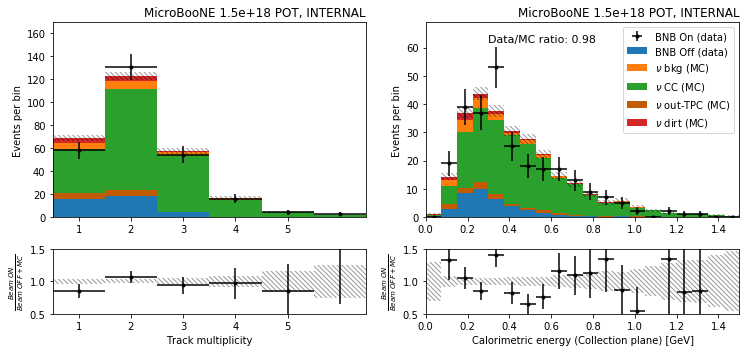

In [38]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(6.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

# Left
lab = 'Track multiplicity'
N=6
x_min = 0.5
x_max = 6.5
data = [df_daughters[i].query(query_event)['num_tracks'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_event).query('~mc_nu_in_tpc')['num_tracks'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0][0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][0].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0][0].set_ylabel('Events per bin')
ax[0][0].set_title(title_str, loc='right')
ax[0][0].set_ylim(0,1.3*max_val[2])
ax[0][0].set_xticks(range(6))
ax[0][0].set_xlim(x_min,x_max)

# Ratio plots
ax[1][0].set_ylim(0.5,1.5)
ax[1][0].set_xticks(range(6))
ax[1][0].set_xlim(x_min,x_max)
ax[1][0].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].set_xlabel(lab)



# Right
lab = 'Calorimetric energy (Collection plane) [GeV]'
N=20
x_min = 0
x_max = 1.5
data = [df_daughters[i].query(query_event)['caloY'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_event).query('~mc_nu_in_tpc')['caloY'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][1].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)

ax[0][1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][1].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][1].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0][1].legend()
ax[0][1].set_ylabel('Events per bin')
ax[0][1].set_title(title_str, loc='right')
ax[0][1].set_ylim(0,1.3*max_val[2])
ax[0][1].text(0.3, ax[0][1].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
ax[0][1].set_xlim(x_min,x_max)

# Ratio plots
ax[1][1].set_ylim(0.5,1.5)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_xlabel(lab)

fig.tight_layout()
fig.savefig(outdir+"numu_tracks_calo.pdf", bbox_inches="tight")